In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [279]:
results = pd.read_csv('results_bcast_full.csv')
print(results.columns, results.shape)
results.head()

Index(['Size', 'Avg Latency(us)', 'Min Latency(us)', 'Max Latency(us)',
       'Iterations', 'NP_total', 'ALGO', 'ALGO_NAME'],
      dtype='object') (640, 8)


,Size,Avg Latency(us),Min Latency(us),Max Latency(us),Iterations,NP_total,ALGO,ALGO_NAME
0,1,1.73,0.11,3.36,30000,2,0,default
1,2,1.72,0.10,3.33,30000,2,0,default
2,4,1.73,0.10,3.36,30000,2,0,default
3,8,1.74,0.11,3.37,30000,2,0,default
4,16,1.79,0.11,3.46,30000,2,0,default


# 3D Heatmap

In [280]:
results['ALGO_NAME'].unique()

array(['default', 'chain', 'pipeline', 'binary tree'], dtype=object)

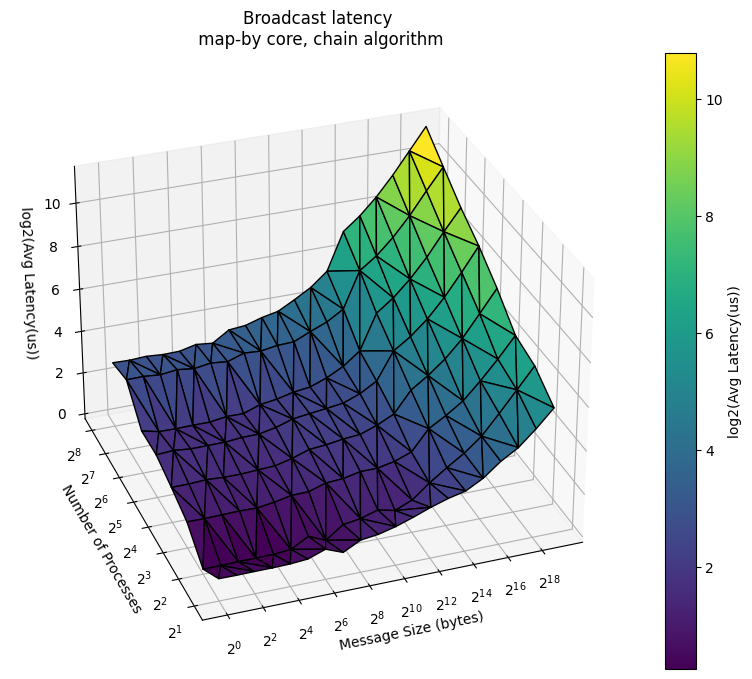

In [281]:
ALGO = 'chain'
algorithm_data = results[results['ALGO_NAME'] == ALGO]

# Extract relevant columns
x = algorithm_data['Size']
y = algorithm_data['NP_total']
z = algorithm_data['Avg Latency(us)']

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D mesh heatmap
mesh = ax.plot_trisurf(np.log2(x), np.log2(y), np.log2(z), cmap='viridis', edgecolor='k')

# Set labels
ax.set_xlabel('Message Size (bytes)')
ax.set_ylabel('Number of Processes')
ax.set_zlabel('log2(Avg Latency(us))')

ax.set_title(f'Broadcast latency\n map-by core, {ALGO} algorithm')
fig.colorbar(mesh, ax=ax, label='log2(Avg Latency(us))')
ax.view_init(elev=30, azim=-110)  # Adjust the elevation and azimuth angles as needed

# Set y-axis tick labels
yticks_values = [2, 4, 8, 16, 32, 64, 128, 256]
yticks_labels = ['$2^{%s}$' % int(np.log2(val)) for val in yticks_values]
ax.set_yticks(np.log2(yticks_values))
ax.set_yticklabels(yticks_labels)

# Set x-axis tick labels
xticks_labels = ['$2^{%s}$' % int(val) for val in np.log2(x.unique())]
ax.set_xticks(np.log2(x.unique())[::2])
ax.set_xticklabels(xticks_labels[::2])

# Show the plot
plt.show()


# Simple model

In [299]:
import math

def succ_left(p):
  h = math.floor(math.log2(p+1))
  if h == 0:
    i = 0
  else:
    i = 2*(p-2**h+1) + p//(2**(h+1)-2)
  return 2**(h+1) - 1 + i

def succ_right(p):
  h = math.floor(math.log2(p+1))
  if h == 0:
    i = 0
  else:
    i = 2*(p-2**h+1) + p//(2**(h+1)-2)
  return 2**h + 2**(h+1) - 1 + i

In [318]:
import matplotlib.pyplot as plt


# The main problem is different latencies between different cores based on CCD / CCX / numa region / socket / node
# CCX -> sets of 4 core complexes sharing same l3

# Each CPU has 64 cores organized in 8 different CCD (Core Complex Die), each couple of closest CCD represent a NUMA region.
# Each CCD contain 2 CCX (Core Complex) with 4 cores each, they share same L3 cache.


# All measured in microseconds (1e^-6)
LATENCY_CCX = 0.15e-6
LATENCY_CCD_DIFF_CCX = 0.31e-6
LATENCY_NUMA = 0.34e-6
LATENCY_SOCKET = 0.36e-6
LATENCY_DIFF_SOCKET = 0.65e-6
LATENCY_DIFF_NODE = 1.82e-6

# Modulo sizes
CCX = 4
# CCD_DIFF_CCX = 8
NUMA = 16
SAME_SOCKET = 32
SOCKET = 64
NODE = 128

CHAIN_TIMES = np.zeros((255,), dtype=np.float32)
for i in range(255):
  j = i+1
  if i // CCX == j // CCX: CHAIN_TIMES[i] = LATENCY_CCX
  elif i // NUMA == j // NUMA: CHAIN_TIMES[i] = LATENCY_CCD_DIFF_CCX
  elif i // SAME_SOCKET == j // SAME_SOCKET: CHAIN_TIMES[i] = LATENCY_NUMA
  elif i // SOCKET == j // SOCKET: CHAIN_TIMES[i] = LATENCY_SOCKET
  elif i // NODE == j // NODE: CHAIN_TIMES[i] = LATENCY_DIFF_SOCKET
  else: CHAIN_TIMES[i] = LATENCY_DIFF_NODE

MATRIX_TIMES = np.zeros((255, 255), dtype=np.float32)
for i in range(255):
  for j in range(255):
    if i == j:
      MATRIX_TIMES[i][j] = 0
    elif i//4 == j//4:
      MATRIX_TIMES[i][j] = LATENCY_CCX
    elif i//16 == j//16:
      MATRIX_TIMES[i][j] = LATENCY_CCD_DIFF_CCX
    elif i//32 == j//32:
      MATRIX_TIMES[i][j] = LATENCY_NUMA
    elif i//64 == j//64:
      MATRIX_TIMES[i][j] = LATENCY_SOCKET
    elif i//128 == j//128:
      MATRIX_TIMES[i][j] = LATENCY_DIFF_SOCKET
    else:
      MATRIX_TIMES[i][j] = LATENCY_DIFF_NODE

# find if cores are mapped first on node1 and then on node2

def pipeline_latency(intra_node_lat, inter_node_lat, num_proc):
    return inter_node_lat * (num_proc // 2) + intra_node_lat * (num_proc // 2)

# Chain latency
# small message so no splitting requires same number of steps as number of nodes
# as cores are mapped first on node1 and then on node2 we can assume
# a single communication between the two nodes with higher latency and a lot
# more communications intranode, so we estimate a mean latency intranode and
# a mean latency inter node and weight the two accordingly to number of processes used
def chain_latency(num_proc):
    time = 0
    for j in range(1, num_proc):
        time += CHAIN_TIMES[j - 1]
    return time


def bin_tree_latency(n_proc):
  time = 0
  for j in range(1, math.floor(math.log2(n_proc)) + 1):
    step_j = []
    for k in range(j - 1, min(math.floor(math.log2(n_proc)) - 1, j - 1) + 1):
      left = succ_left(k)
      right = succ_right(k)
      step_j.append(MATRIX_TIMES[k][left] + MATRIX_TIMES[k][right])
    print(step_j)
    time += max(step_j)
  return time

n_proc = list(range(1, 257))

# Calculate estimated latency for each number of processors
est_lat_chain = np.array([chain_latency(N) for N in n_proc])
est_lat_chain *= 10**6

est_lat_bin_tree = np.array([bin_tree_latency(N) for N in n_proc])
est_lat_bin_tree *= 10**6

# est_lat_pipeline = np.array([pipeline_latency(intra_node_lat, inter_node_lat, N) for N in n_proc])
# est_lat_pipeline *= 10**6

[3e-07]
[3e-07]
[3e-07]
[4.6e-07]
[3e-07]
[4.6e-07]
[3e-07]
[4.6e-07]
[3e-07]
[4.6e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2e-07]
[6.2e-07]
[3e-07]
[4.6e-07]
[6.2e-07]
[6.2

In [328]:
results = pd.read_csv('results_bcast_fixedsize.csv')
print(results.columns, results.shape)
results.head()

Index(['Size', 'Avg Latency(us)', 'Min Latency(us)', 'Max Latency(us)',
       'Iterations', 'NP_total', 'ALGO', 'ALGO_NAME'],
      dtype='object') (512, 8)


,Size,Avg Latency(us),Min Latency(us),Max Latency(us),Iterations,NP_total,ALGO,ALGO_NAME
0,4,1.73,0.11,3.36,30000,2,0,default
1,4,0.78,0.55,0.96,30000,4,0,default
2,4,1.25,0.67,1.83,30000,6,0,default
3,4,2.07,0.63,3.52,30000,8,0,default
4,4,4.11,0.77,6.37,30000,10,0,default


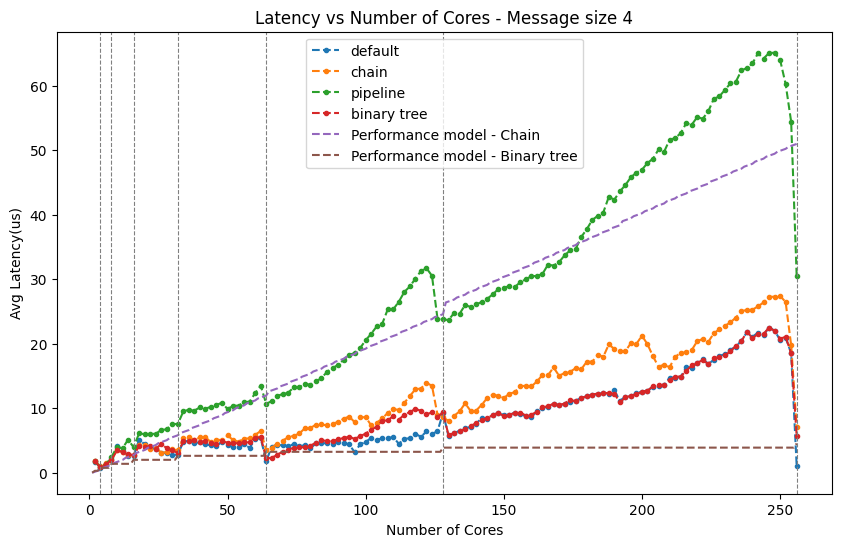

In [332]:
# Extract relevant columns
cores = results['NP_total']
latency = results['Avg Latency(us)']
algo_names = results['ALGO_NAME'].unique()

# Create a line plot with vertical lines
fig, ax = plt.subplots(figsize=(10, 6))

MESSAGE_SIZE = 4

# Plot for each algorithm
for algo_name in algo_names:
    algo_data = results[(results['ALGO_NAME'] == algo_name) & (results['Size'] == MESSAGE_SIZE)]
    ax.plot(algo_data['NP_total'], algo_data['Avg Latency(us)'], '--o', markersize=3, label=algo_name)

ax.plot(n_proc, est_lat_chain, '--', label='Performance model - Chain')
ax.plot(n_proc, est_lat_bin_tree, '--', label='Performance model - Binary tree')
# ax.plot(n_proc, est_lat_pipeline, '--', label='Performance model - Pipeline')

# Add vertical lines for specific numbers of processors
vertical_lines = [4, 8, 32, 16, 64, 128, 256]
for line in vertical_lines:
    ax.axvline(x=line, color='gray', linestyle='--', linewidth=0.8)

# Set labels and title
ax.set_xlabel('Number of Cores')
ax.set_ylabel('Avg Latency(us)')
ax.set_title(f'Latency vs Number of Cores - Message size {MESSAGE_SIZE}')

# ax.set_xticks(n_proc)

ax.legend()
plt.show()

In [331]:
algo_name = 'pipeline'
results[(results['ALGO_NAME'] == algo_name) & (results['Size'] == MESSAGE_SIZE)]

,Size,Avg Latency(us),Min Latency(us),Max Latency(us),Iterations,NP_total,ALGO,ALGO_NAME
256,4,1.76,0.11,3.40,30000,2,3,pipeline
257,4,0.90,0.75,1.04,30000,4,3,pipeline
258,4,1.33,0.87,1.65,30000,6,3,pipeline
259,4,2.39,0.12,4.76,30000,8,3,pipeline
260,4,4.02,0.11,5.86,30000,10,3,pipeline
...,...,...,...,...,...,...,...,...
379,4,65.10,0.33,119.49,30000,248,3,pipeline
380,4,63.99,0.35,117.59,30000,250,3,pipeline
381,4,60.25,0.33,114.04,30000,252,3,pipeline
382,4,54.42,0.12,107.33,30000,254,3,pipeline
